# L3T12 Submission

This dataset is from the US Arrests Kaggle challenge (link). 

A description of the data is given as: “This data set contains statistics, in arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.”

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

# Load dataset
df = pd.read_csv('UsArrests.csv')
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


### Data Preprocessing

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000


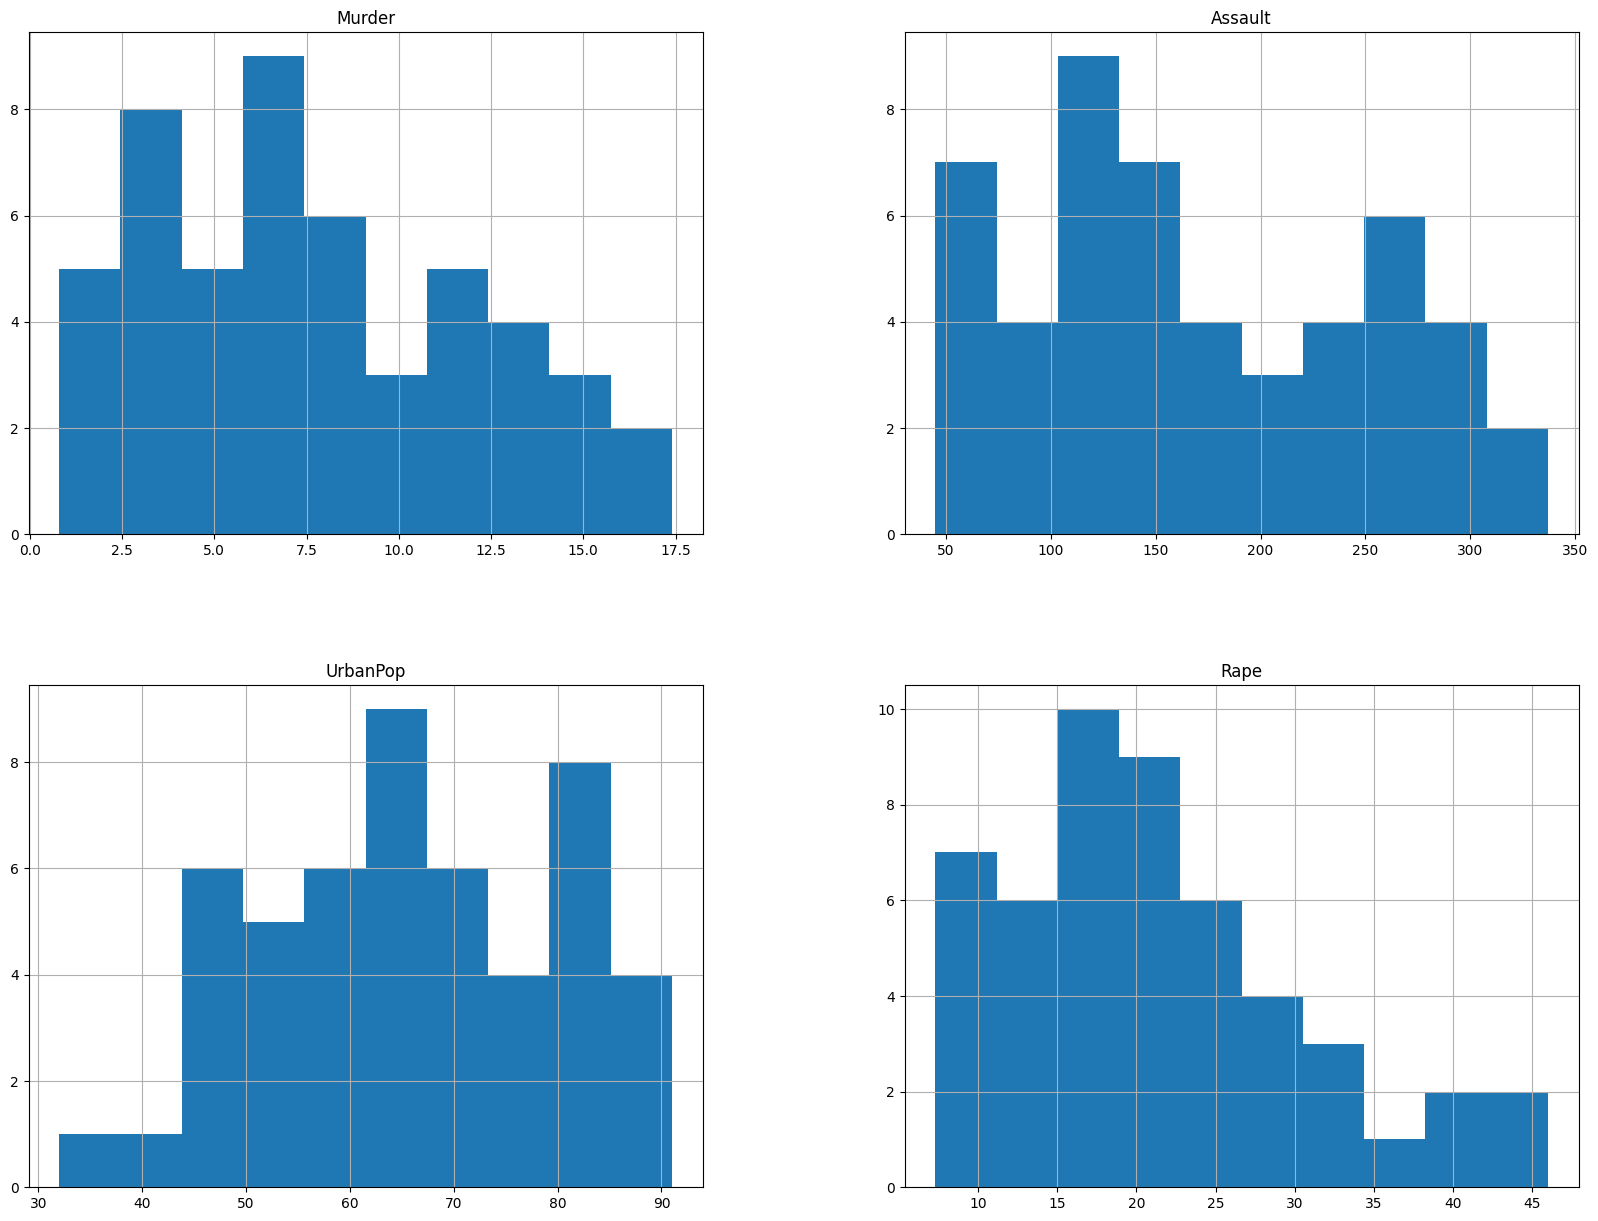

In [9]:
# Check for missing values
print(df.isna().sum())

# Summary statistics
print(df.describe())

# Visualizations
df.hist(bins=10, figsize=(20,15))
plt.show()

In [12]:
# Since the mean and standard deviation for Assault cases are much higher, and we can see the distributions are not normal, 
# we will scale the data using normalization.

# Select only numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Initialize a scaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


### Correlation Matrix

From the correlation matrix below, we can note:
- Assault and Murder are highly correlated at 0.8
- Rape is moderately correlated with Assault, Murder, and UrbanPop at 0.56, 0.67, 0.41
- UrbanPop has little to no correlation with Murder and Assault. 

/var/folders/pr/4fhflc9972x5wxl_w6d2bfvm0000gn/T/ipykernel_45520/1212454074.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


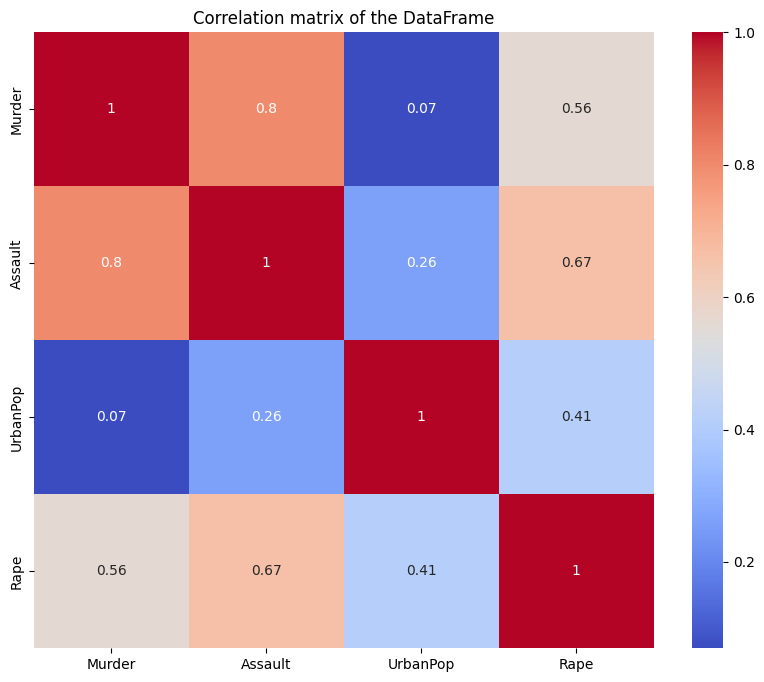

In [13]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10,8))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of the DataFrame')
plt.show()

## Principal Component Analysis

In [20]:
pca = PCA()
data_pca = pca.fit_transform(df[numerical_cols])

# Convert the array into a dataframe
df_pca = pd.DataFrame(data=data_pca, columns=['PC'+str(i+1) for i in range(len(df.columns)-1)])

# Calculate the proportion of variance explained
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Create a dataframe for the explained variance and the principal components
df_variance = pd.DataFrame({'PC': ['PC'+str(i+1) for i in range(len(df.columns)-1)], 
                            'Standard Deviation': np.sqrt(pca.explained_variance_),
                            'Proportion of Variance Explained': explained_variance,
                            'Cumulative Proportion': cumulative_explained_variance})

print(df_variance)

    PC  Standard Deviation  Proportion of Variance Explained  \
0  PC1            0.415855                          0.642729   
1  PC2            0.247707                          0.228046   
2  PC3            0.147609                          0.080979   
3  PC4            0.113936                          0.048246   

   Cumulative Proportion  
0               0.642729  
1               0.870775  
2               0.951754  
3               1.000000  


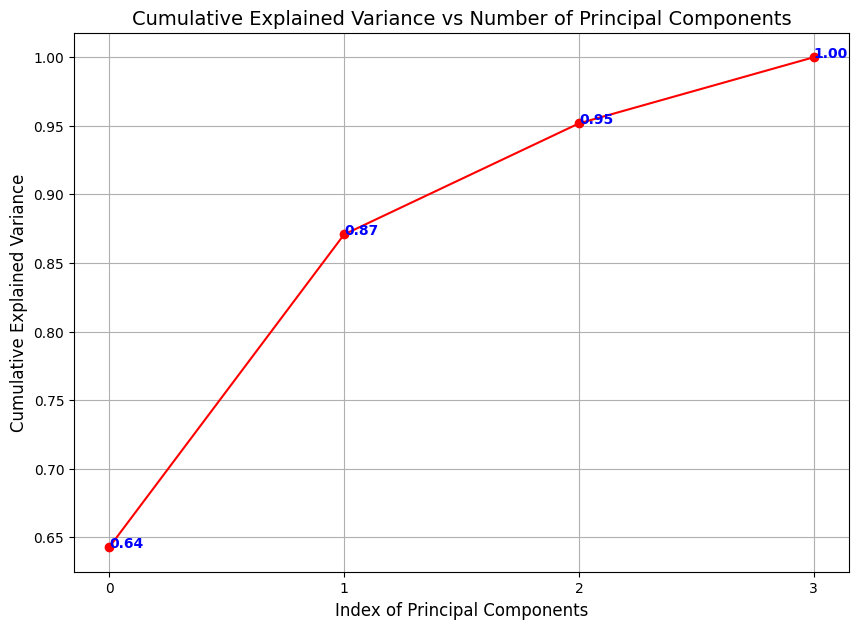

In [26]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('Index of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance vs Number of Principal Components', fontsize=14)
plt.xticks(np.arange(0, len(explained_variance), step=1)) # Change the x-axis to display number of components
for i, ev in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(i, ev, f'{ev:.2f}', color='blue', fontweight='bold') # add the cumulative variance as text on each point
plt.grid()
plt.show()

Assessing the correlation between the principal components and the original variables:

In [42]:
# Convert to DataFrame
pca_df = pd.DataFrame(data_pca, columns=["PC1", "PC2", "PC3", "PC4"])

# Concatenate with original data
full_df = pd.concat([df[numerical_cols].reset_index(drop=True), pca_df], axis=1)

# Calculate correlations
correlations = full_df.corr()

# Select correlations between original variables and principal components
correlations_with_pcs = correlations.loc[numerical_cols, ["PC1", "PC2", "PC3", "PC4"]]

print(correlations_with_pcs)

               PC1       PC2       PC3       PC4
Murder    0.867751  0.366263 -0.150877  0.300161
Assault   0.941172  0.132032 -0.136898 -0.279324
UrbanPop  0.389113 -0.888958 -0.229137  0.076427
Rape      0.824605 -0.231507  0.514979  0.035041


### PCA Analysis

We can see from the cumulative variances, that the first two components (PC1 and PC2) account for 87% of the variance; and the first 3 components (PC1, 2 and 3) account for 95% of the variance. 

From the correlations, we can see that:
- PC1 is highly correlated to Murder, Assault, Rape; and low-medium correlation to UrbanPop: this possibly could represent our observation above that Rape cases showed correlation to all the other variables. It also suggests that cases of one crime does typically mean other types of crime exist (which makes sense in real life). 
- PC2 is highly negatively correlated to UrbanPop; and low-medium correlation to the other 3 variables: this could represent our findings that UrbanPop has low correlations to Assault and Murder; and at most, only mid-level of correlation to Rape. The negative correlation in UrbanPop of this component may be to correct / negate what was captured or overstated about UrbanPop in other components. 
- While Rape cases do have a noticeable correlation with all the variables - it does not have as strong of a correlation as Assault and Murder - suggesting that there is something unique about Assault/Murder cases - being captured possibly by PC3. 

## Clustering

You are also required to do an application of two clustering techniques and an analysis of the clusters they generate. Try and see if you can find anything common within each cluster that has been found.

### Hierarchical Clustering Analysis

We can see from the different techiques below, that the method which forms the most distinct clusters are: 
- complete: showing 2 very clear and seperate clusters. This matches our findings from PCA, where there just 2 components captured 87% of the variance. 
- average: shows 3 clusters, with the red one being most distinct and the orange & green clusters being slightly less distinct. This slightly mirrors the findings of the PCA analysis, where - while there was an improvement for explained variance from PC2 to PC3, it is more marginal. This indicates there is possibly less variance between the extra component which we can see in the average linkage diagram.

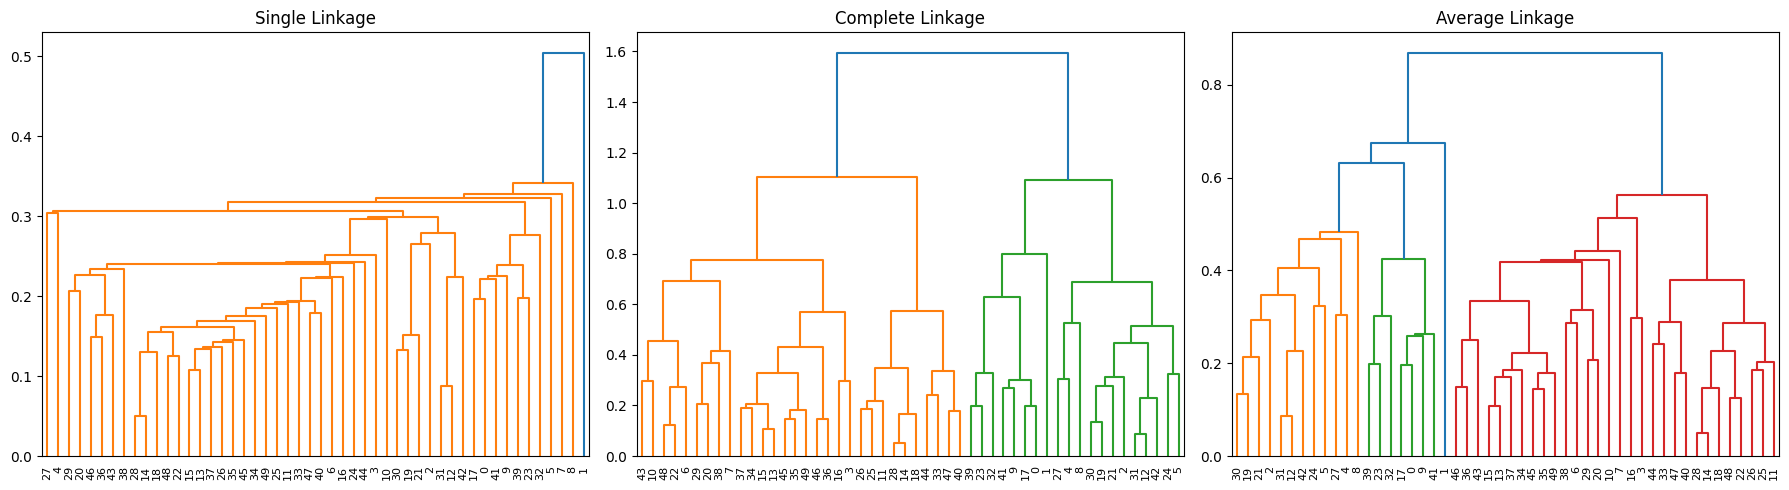

In [38]:
# Import required packages
from scipy.cluster.hierarchy import dendrogram, linkage

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, method in zip(axes.flatten(), ['single', 'complete', 'average']):
    linked = linkage(data_pca, method=method)
    dendrogram(linked, ax=ax, orientation='top', 
               labels=list(df.index), distance_sort='descending', 
               show_leaf_counts=True)
    ax.set_title(f'{method.capitalize()} Linkage')

plt.tight_layout()
plt.show()

### K-Means Clustering Analysis

We can see a sharp drop-off in the silhouette score between 2 to 3. While the score does increase slightly at k = 4, this is still low compared to k = 2. 

In the clusters scatter graph comparing k = 2 and k = 4:
- at k = 2, we can see a resonably clear distinction between the 2 clusters (left & right) with a gap inbetween the two sides. This seems to be the identified seperation / categorisation for what can be considered high crime and low crime states. 
- at k = 3 and k = 4, there is not as much of a clear gap between the clusters as in the categorisation in k = 2. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

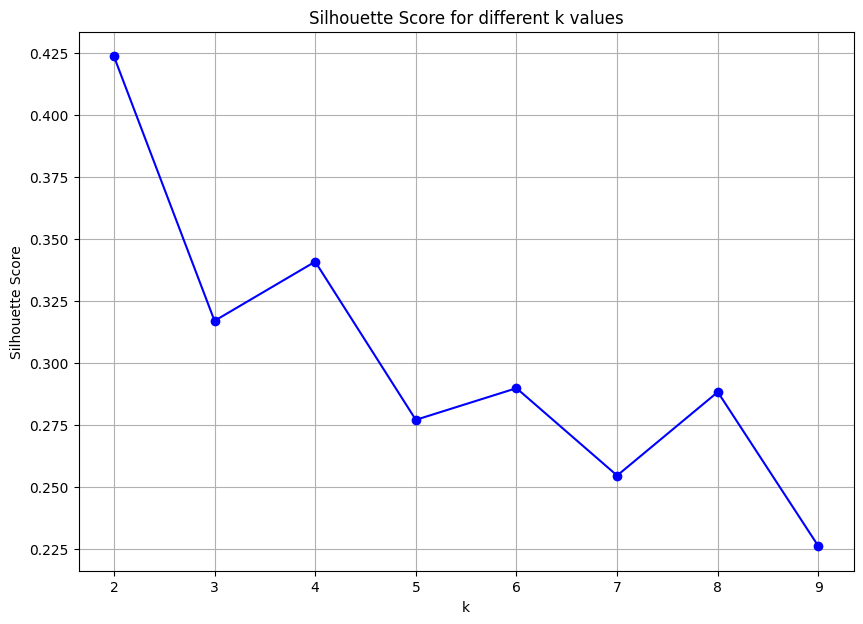

In [37]:
from sklearn.metrics import silhouette_score

# Define a range for k
k_values = range(2, 10)

# List to store silhouette scores
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df[numerical_cols])
    sil_score = silhouette_score(df[numerical_cols], labels)
    sil_scores.append(sil_score)

# Plot
plt.figure(figsize=(10,7))
plt.plot(k_values, sil_scores, 'bo-')
plt.title('Silhouette Score for different k values')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


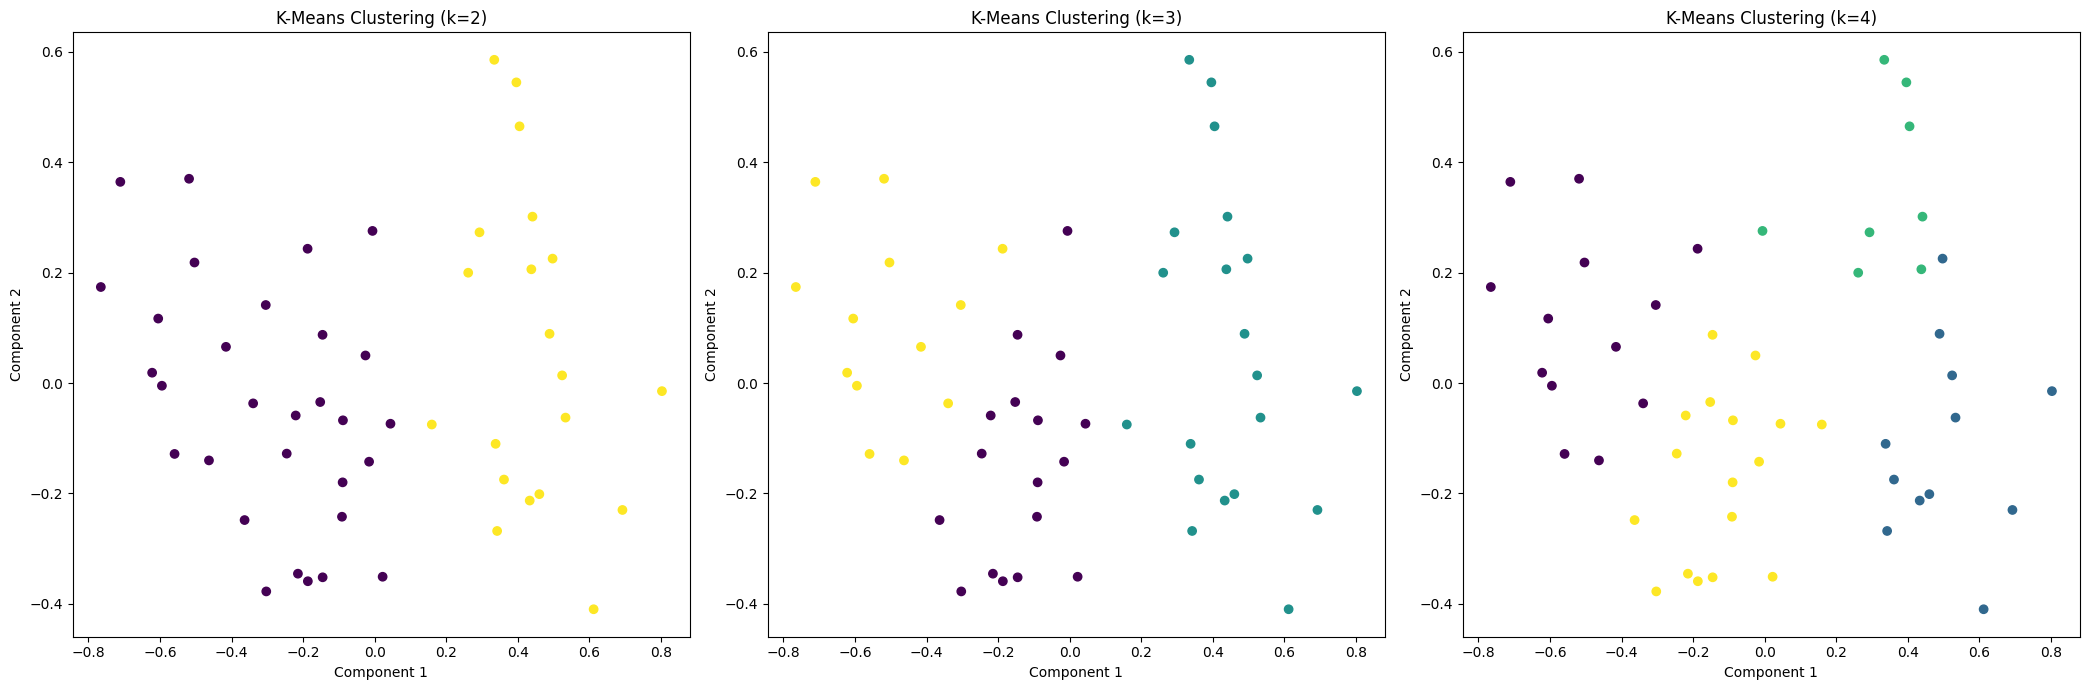

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# List to save the labels from k-means
clusters = []

for ax, k in zip(axes.flatten(), [2, 3, 4]):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df[numerical_cols])
    clusters.append(labels)
    
    # plot
    ax.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
    ax.set_title(f'K-Means Clustering (k={k})')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

plt.tight_layout()
plt.show()

# Final Conclusion

- The PCA, hierarchical clustering, and K-means clustering analyses consistently indicate that the dataset's structure can be effectively captured by two main clusters or components.
- The two components / categories - PC1 and PC2 approximately describe, respectively:
- PC1: a generalised indicator of all 3 crime rates, or perhaps more specifically: rape cases as a gauge for other crime rates (murder and assault) in a state (strong positive correlations)
- PC2: urban population size (strong negative correlation)

Note that our conclusions are limited by our methods. We have noticed a possible 3rd component also from PCA and hierachical clustering analysis - potentially describing the extremely high correlation between Assault and Murder cases in psrticular. However, this was not as clear / distinct and could be another area for further investigation. 